# < 8. 뉴스 요약봇 만들기 >

### 학습목표
- Extractive/Abstractive summarization 이해하기
- 단어장 크기를 줄이는 다양한 text normalization 적용해보기
- seq2seq의 성능을 Up시키는 Attention Mechanism 적용하기

---

## 8.2 텍스트 요약(Text Summarization)이란?

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-21-1.png)

- 텍스트 요약이란 위 그림과 같이 긴 길이의 문서 원문을 핵심 주제만으로 구성된 짧은 요약 문장들로 변환하는 것을 말한다.
- 이때 중요한 것은 요약 전후에 정보 손실 발생이 최소화되어야 한다는 점이다. 이것은 정보를 압축하는 과정과 같다.
- 요약은 크게 추출적 요약과 추상적 요약의 두 가지 접근으로 나누어볼 수 있다

### 추출적 요약(Extractive Summarization)
-  단어 그대로 원문에서 문장들을 추출해서 요약하는 방식
- 10개의 문장으로 구성된 텍스트가 있다면, 그중 핵심적인 문장 3개를 꺼내와서 3개의 문장으로 구성된 요약문을 만드는 식이다. 그런데 꺼내온 3개의 문장이 원문에서 중요한 문장일 수는 있어도, 3개의 문장의 연결이 자연스럽지 않을 수는 있다. 결과로 나온 문장들 간의 호응이 자연스럽지 않을 수 있다는 것이다. 딥 러닝보다는 주로 전통적인 머신 러닝 방식에 속하는 텍스트 랭크(TextRank)와 같은 알고리즘을 사용해서 이 방법을 사용한다고 한다

### 추상적 요약(Abstractive Summarization)
- 원문으로부터 내용이 요약된 새로운 문장을 생성해내는 것이다. 여기서 새로운 문장이라는 것은 결과로 나온 문장이 원문에 원래 없던 문장일 수도 있다는 것을 의미한다. 자연어 처리 분야 중 자연어 생성(Natural Language Generation, NLG)의 영역인 셈이다
- 추출적 요약은 원문을 구성하는 문장 중 어느 것이 요약문에 들어갈 핵심문장인지를 판별한다는 점에서 문장 분류 문제로 볼 수 있다

---

## 8.3 인공 신경망으로 텍스트 요약 훈련시키기

### seq2seq
- 두 개의 RNN 아키텍처를 사용하여 입력 시퀀스로부터 출력 시퀀스를 생성해 내는 자연어 생성 모델

![](https://d3s0tskafalll9.cloudfront.net/media/images/E-21-2.max-800x600.png)

원문을 첫 번째 RNN인 인코더로 입력하면, 인코더는 이를 하나의 고정된 벡터로 변환한다. 이 벡터를 문맥 정보를 가지고 있는 벡터라고 하여 컨텍스트 벡터(context vector)라고 한다. 두 번째 RNN인 디코더는 이 컨텍스트 벡터를 전달받아 한 단어씩 생성해내서 요약 문장을 완성한다

### LSTM과 컨텍스트 벡터
- seq2seq를 구현할때, 인코더/디코더로 바닐라 RNN이 아니라 LSTM을 사용할거다

![](https://d3s0tskafalll9.cloudfront.net/media/images/E-21-3.max-800x600.png)

LSTM이 바닐라 RNN과 다른 점은 다음 time step의 셀에 hidden state뿐만 아니라, cell state도 함께 전달한다는 점이다. 인코더가 디코더에 전달하는 컨텍스트 벡터 또한 hidden state h와 cell state c 두개의 값 모두 존재해야 한다는 뜻이다

### 시작 토큰과 종료 토큰
![](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-21-4.png)

seq2seq 구조에서 디코더는 시작 토큰 SOS가 입력되면, 각 시점마다 단어를 생성하고 이 과정을 종료 토큰 EOS를 예측하는 순간까지 멈추지 않는다. 다시 말해 훈련 데이터의 예측 대상 시퀀스의 앞,뒤에는 시작 토큰과 종료 토큰을 넣어주는 전처리를 통해 어디서 멈춰야 하는지 알려줄 필요가 있다

### 어텐션 메커니즘을 통한 새로운 컨텍스트 벡터 사용하기
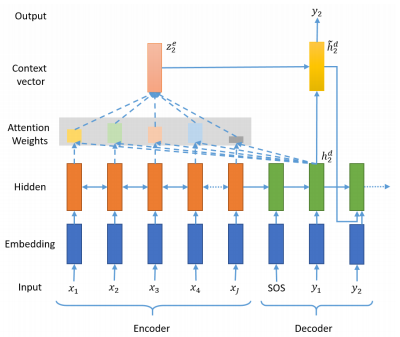

- 기존에 배운 seq2seq를 수정하고 새로운 모듈을 붙여 모델의 성능을 높여본다. 기존의 seq2seq는 인코더의 마지막 time step의 hidden state를 컨텍스트 벡터로 사용했다. 하지만 RNN 계열의 인공 신경망의 한계로 인해 이 컨텍스트 정보에는 이미 입력 시퀀스의 많은 정보가 손실이 된 상태가 된다
- 어텐션 메커니즘(Attention Mechanism) 은 이와 달리, 인코더의 모든 step의 hidden state의 정보가 컨텍스트 벡터에 전부 반영되도록 하는 것. 하지만 인코더의 모든 hidden state가 동일한 비중으로 반영되는 것이 아니라, 디코더의 현재 time step의 예측에 인코더의 각 step이 얼마나 영향을 미치는지에 따른 가중합으로 계산되는 방식
- 컨텍스트 벡터를 구성하기 위한 인코더 hidden state의 가중치 값은 디코더의 현재 스텝이 어디냐에 따라 계속 달라진다. 즉, 디코더의 현재 문장 생성 부위가 주어부인지 술어부인지 목적어인지 등에 따라 인코더가 입력 데이터를 해석한 컨텍스트 벡터가 다른 값이 된다는 것

### 정리
1. seq2seq를 사용한다
2. RNN 계열 중 LSTM을 사용하므로 hidden state 뿐만 아니라 cell state도 사용해야 한다
3. 디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙인다
4. seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측을 시작한다
5. seq2seq 기본 모델과 달리, 어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산한다
6. 계산된 컨텍스트 벡터를 이용해서 디코더는 다음 등장할 단어를 예측한다

---

## 8.4 데이터 준비하기
- 이번실습에서는 NLTK의 불용어(stopwords)를 사용한다
    - Natural Language Toolkit의 축약어로 영어 기호, 통계, 자연어 처리를 위한 라이브러리
    - 이 NLTK에는 I, my, me, over, 조사, 접미사와 같이 문장에는 자주 등장하지만, 의미를 분석하고 요약하는 데는 거의 의미가 없는 100여개의 불용어가 미리 정리되어 있다
    - 이를 이용해 다운로드한 리뷰 파일에서 불용어를 제거하는 작업을 진행한다

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


In [2]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


- 전체 데이터 중 Summary열과 Text열만 훈련에 사용

In [4]:
data = data[['Text', 'Summary']]
data.head()

data.sample(15)

,Text,Summary
96064,I bought this antler chew bone for my daughter...,Perfect for Agressive Chewers!
41153,"This is an excellent product, both tastey and ...",Very good taste also nice price!
77642,"It's not black cherry like a soda, it's black ...",Switchin' it up
13767,This tea is very tasty. I drink one cup of hot...,Gordolobo Tea....
69561,this is my drink of choice. I'm addicted. I ...,As a person who has never really liked tea
67251,This product looks disgusting in the package. ...,stomach turning!!!
71538,"I switched to the ""Get Naked"" chew sticks, whi...","Great Low Calorie, Healthy Chew Treat"
86402,"<a href=""http://www.amazon.com/gp/product/B000...",Hmm Good!
53619,Simply excellent! Great tasting and works. I h...,lean body
98927,"Good ingredients, excellent taste. The mutts a...",Dog Approved


---

## 8.5 데이터 전처리하기 (1) 데이터 정리하기

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


- Text 자체가 중복이 된 경우에는 중복 샘플이므로 제거해야한다

In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


In [7]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


#### dropna()
- 데이터프레임에서 Null을 제거할때 사용하는 함수

In [8]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수: ', (len(data)))

전체 샘플수:  88425


### 텍스트 정규화와 불용어 제거
- 단어들 중에서는 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우가 있다
- 예를 들어 it'll은 it will과 같고, mustn't과 must not은 사실 같은 표현
- 텍스트 정규화 : 미리 같은 표현을 통일시켜주는 것

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


#### 불용어
- 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들
- NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거

In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

이 작업 외에도 모든 영어 문자는 소문자로 만들고, 섞여있는 html 태크를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


- 함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 Summary 전처리할 때는 호출하지 않을 예정
-  Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Summary에는 남아 있는 게 더 좋을 것 같아서

In [12]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


- Text 경우에는 불용어 제거, Summary의 경우에는 불용어를 제거하지 않는다

In [13]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


In [14]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


#### Null값 확인

In [15]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [16]:
data.isnull().sum()

Text        0
Summary    70
dtype: int64

In [17]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


---

## 8.6 데이터 전처리하기 (2) 훈련데이터와 테스트데이터 나누기

### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


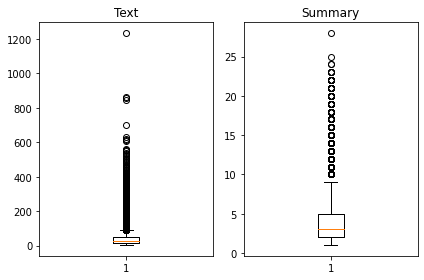

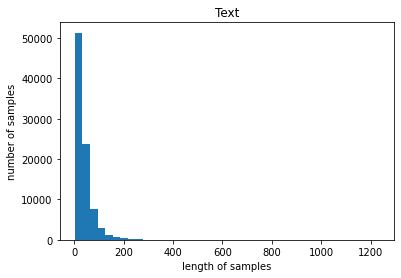

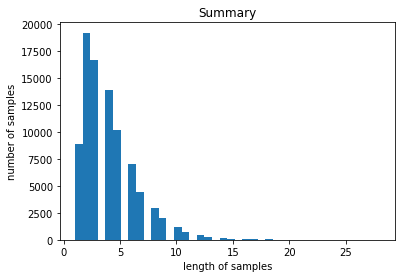

In [18]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
# Summary의 적절한 최대 길이를 임의로 정한다
text_max_len = 50
summary_max_len = 8

In [20]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [21]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


- Text열의 경우에는 약 23%의 샘플들의 내용이 망가진다
- 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 정제

In [22]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


### 시작 토큰과 종료 토큰 추가하기
- 디코더는 시작토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈춘다
![](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-21-4.png)
- seq2seq 훈련을 위해서 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있다
- 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가
- 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정한다

In [23]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [24]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


### 훈련 데이터와 테스트 데이터 분리

In [25]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[63261 37094 11051 ...  5552  5574 41377]


In [26]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [27]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


In [28]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


---

## 8.7 데이터 전처리하기 (3) 정수 인코딩

### 단어 집합(vocabulary) 만들기 및 정수 인코딩
- 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 한다
- 각 단어에 고유한 정수를 맵핑하는 작업이 필요하다
- 이 과정을 단어 집합을 만든다고 표현한다

### (1) encoder_input_train

In [29]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


- 생성된 단어 집합은 src_tokenizer.word_index에 저장
- 빈도수가 낮은 단어들은 훈련 데이터에서 제외

In [30]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31865
등장 빈도가 6번 이하인 희귀 단어의 수: 23617
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8248
단어 집합에서 희귀 단어의 비율: 74.11580103561903
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.375937771429066


- encoder_input_train 에는 3만여개의 단어가 있다
- 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.39%밖에 되지 않는다
- 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 한다
- 이를 제외한 단어 집합의 크기를 8천여개로 계산해서 이와 비슷하게 단어 집합의 크기를 8000으로 제한

In [31]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


#### texts_to_sequences()
- 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행

In [32]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2278, 394, 519, 146, 1027, 39, 1223, 833, 1395, 1033, 730, 519, 207, 1361, 1170, 330, 818, 227, 286, 146], [484, 2299, 6816, 7227, 266, 3672, 143], [91, 62, 183, 707, 287, 702, 62, 702, 456, 172, 61, 223, 100, 12, 173, 1014, 430, 165, 131, 20, 951, 300, 325, 109, 108, 9, 183, 707, 287, 929, 391, 180, 127, 10, 18, 18, 930, 480, 888, 105]]


### (2) decoder_input_train

In [33]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [57]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10458
등장 빈도가 5번 이하인 희귀 단어의 수: 6511
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 3947
단어 집합에서 희귀 단어의 비율: 62.25855804169057
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3983469364889203


In [35]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 29, 60, 18], [1, 120, 182, 621], [1, 161, 11, 10, 58], [1, 4, 7, 1100, 10, 78], [1, 12, 1659, 37, 5, 20]]
target
decoder  [[29, 60, 18, 2], [120, 182, 621, 2], [161, 11, 10, 58, 2], [4, 7, 1100, 10, 78, 2], [12, 1659, 37, 5, 20, 2]]


- 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있다
- 여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않는다
- 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 거다

In [36]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1283
삭제할 테스트 데이터의 개수 : 321
훈련 데이터의 개수 : 51372
훈련 레이블의 개수 : 51372
테스트 데이터의 개수 : 12842
테스트 레이블의 개수 : 12842


### 패딩하기

In [37]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


---

## 8.8 모델 설계하기

In [38]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

- 임베딩 벡터의 차원은 128, hidden state의 크기는 256으로
    - hidden state는 LSTM에서 얼만큼의 수용력을 가질지를 결정하는 파라미터
    - 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수
    - 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니다
- 인코더의 LSTM은 총 3개의 층으로 구성
- LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용
    - 일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합을 해결
    - recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식. 즉 time step의 입력을 랜덤으로 생략. 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지할 수 있다

In [39]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

-  LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 한다

In [40]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

- 디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 한다
- 그렇기 때문에 Dense의 인자로 tar_vocab 을 주고, 활성화 함수로 소프트맥스 함수를 사용

### 어텐션 메커니즘
- 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법
- 어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻
- 참고로 여기서 사용하는 어텐션 함수는 Bahdanau 스타일의 어텐션

In [41]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

---

## 8.9 모델 훈련하기

In [43]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 141s 654ms/step - loss: 2.6961 - val_loss: 2.4319
Epoch 2/50
201/201 [==============================] - 130s 646ms/step - loss: 2.3730 - val_loss: 2.2909
Epoch 3/50
201/201 [==============================] - 130s 646ms/step - loss: 2.2150 - val_loss: 2.1671
Epoch 4/50
201/201 [==============================] - 131s 652ms/step - loss: 2.0974 - val_loss: 2.0833
Epoch 5/50
201/201 [==============================] - 132s 658ms/step - loss: 2.0162 - val_loss: 2.0210
Epoch 6/50
201/201 [==============================] - 132s 656ms/step - loss: 1.9518 - val_loss: 1.9784
Epoch 7/50
201/201 [==============================] - 131s 654ms/step - loss: 1.8990 - val_loss: 1.9492
Epoch 8/50
201/201 [==============================] - 129s 641ms/step - loss: 1.8543 - val_loss: 1.9241
Epoch 9/50
201/201 [==============================] - 130s 645ms/step - loss: 1.8144 - val_loss: 1.9080
Epoch 10/50
201/201 [==============================] - 130s 645m

- EarlyStopping : 특정 조건이 충족되면 훈련을 멈추는 역할을 한다
- 위 코드에서는 val_loss을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회 관측되면 학습을 멈추도록 설정돼있다

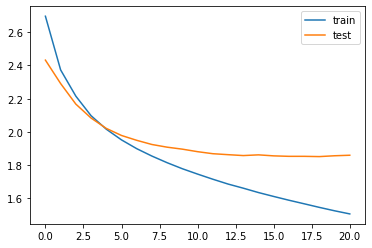

In [44]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

---

## 8.10 인퍼런스 모델 구현하기

- 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비

In [45]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


- seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다
- 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했다
- 그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 한다

In [46]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [47]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [48]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


---

## 8.11 모델 테스트하기
- 테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하다.

#### 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수

In [49]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [50]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : like cleaning cookie sheets like idea chemicals leaking food highly recommend product wife bake time happy results also use sheets rolling pie crust pastries 
실제 요약 : do not bake cookies without this 
예측 요약 :  great product


원문 : sister turned brand quality using cooking morning eggs body moisturizer takes minutes wonderful opportunity slow appreciate take care disappointed 
실제 요약 : excellent product 
예측 요약 :  great product


원문 : yeast choice delivering consistent tasty results prefer sweet yeast never failed give dryer results less one note caution take significant amount time finish said continue use patient good worth wait 
실제 요약 : my of choice 
예측 요약 :  not bad


원문 : gonna keep short sweet long time fan chips salt vinegar say found one salty pungent vinegar right amount flavor glad decided try box guys winner 
실제 요약 : these are the best chips ever 
예측 요약 :  the best chips ever


원문 : tastes like iced tea buy starbucks like better make filtered water great tea 
실제 요약 : love 

예측 요약 :  not bad


원문 : first time tried newman organic extra bold cup used ounces water thought coffee nice flavor little weak side one day brewed cup coffee forgot set water level ounces cuisinart coffee maker ounces result perfect cup coffee absolutely bitterness nice bold flavor overwhelming wish would taste like ounces 
실제 요약 : perfect for me with of water 
예측 요약 :  good coffee


원문 : package contain great assortment mini bars snickers milky way dark milky way minis package something everyone taste preference great snack food grandkids visit also freeze well future snacks highly recommend product 
실제 요약 : great mini chocolate assortment 
예측 요약 :  great snack


원문 : review regarding cookie price set seller cookie fantastic perfect little treat three cookies calories since trying watch weight eat one calories perfect times need something sugary chocolately eat one blow entire day dieting yum yum 
실제 요약 : yummy little treat 
예측 요약 :  delicious


원문 : new flavor great spicy thought wo

- 성능을 개선하기 위해서는 seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법도 있고, 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding), 또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)와 같은 여러 개선 방안들이 존재

---

## 8.12 추출적 요약 해보기
- 패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있다

### 데이터 다운로드

In [51]:
import requests
from summa.summarizer import summarize

In [52]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [53]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

### summarize 사용하기
- summarize(text, ratio, words, split)
    - text(str) : 요약할 텍스트
    - ratio(float, optional) : 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
    - words(int or None, optional) : 출력에 포함될 단어 수
    - split(bool, optional) : True면 문장 list/ False는 조인된 문자열을 반환
- 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행한다. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로입력으로 넣을 수 있다

In [54]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


- 리스트로 출력 결과를 받고 싶으면 split 인자의 값을 True

In [55]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


- 단어의 수로 요약문의 크기를 조절할 수도 있다

In [56]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
